In [1]:
import krakenex
import pandas as pd
import matplotlib.pyplot as plt
from requests.exceptions import HTTPError

In [25]:
kraken = krakenex.API()

In [52]:
def get_order_book(pair, count):
    """Queries the kraken order book.

    Parameters
    ----------
    pair : str 
        Asset pair to get market depth for.
    count : int 
        Maximum number of asks/bids
    df : bool
        Weather to return order book as dataframe (optional).

    Returns
    -------
    dict
        asks : list
            Ask side array of (<price>, <volume>, <timestamp>).
        bids : list 
            Bid side array of (<price>, <volume>, <timestamp>).
    """
    
    try:
        response = kraken.query_public('Depth', {'pair': pair, 'count': count})
    except HTTPError as e:
        print("ERROR: Failed getting order book data for pair={}".format(pair))
    
    obook = response.get('result', {}).get(pair)
    if not obook:
        print("WARNING: Empty response.")
    else:
        asks = [limorder + ['ask'] for limorder in obook['asks']]
        bids = [limorder + ['bid'] for limorder in obook['bids']]
        tabular = asks + bids
        obook = pd.DataFrame(tabular, columns=['price', 'volume', 'timestamp', 'type'])            
        obook = obook.apply(pd.to_numeric, errors='ignore')
        obook['cumvolume'] = obook[['type', 'volume']].groupby('type').cumsum()  # assumes rows are sorted
        
    return obook

In [54]:
ob = get_order_book('XXRPZEUR', 100)
ob.head()

,price,volume,timestamp,type,cumvolume
0,0.27776,581.232,1552261188,ask,581.232
1,0.27777,496.042,1552261185,ask,1077.274
2,0.27778,10000.000,1552261179,ask,11077.274
3,0.27779,7000.000,1552261184,ask,18077.274
4,0.27791,22570.460,1552261186,ask,40647.734


In [55]:
ask_prices = ob.loc[ob['type'] == 'ask', 'price']
ask_volumes = ob.loc[ob['type'] == 'ask', 'volume']
ask_cumvolumes = ob.loc[ob['type'] == 'ask', 'cumvolume']
bid_prices = ob.loc[ob['type'] == 'bid', 'price']
bid_volumes = ob.loc[ob['type'] == 'bid', 'volume']
bid_cumvolumes = ob.loc[ob['type'] == 'bid', 'cumvolume']

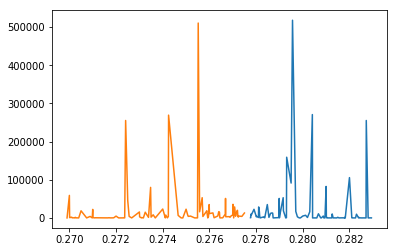

In [56]:
plt.plot(ask_prices, ask_volumes)
plt.plot(bid_prices, bid_volumes);

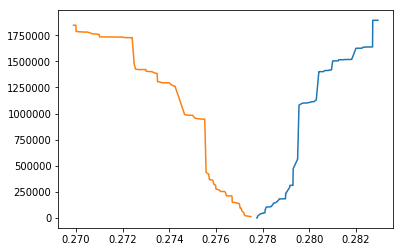

In [57]:
plt.plot(ask_prices, ask_cumvolumes)
plt.plot(bid_prices, bid_cumvolumes);